# Lista 1 - Regressão linear, polinomial e regularização

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
def MSE(Y, Y_hat):
    return np.mean((Y - Y_hat)**2)

def RMSE(Y, Y_hat):
    return np.sqrt(MSE(Y, Y_hat))

In [3]:
def z_score_norm(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    norm = lambda x: (x - mean) / std
    inv_norm = lambda norm_x: norm_x * std + mean
    return norm(data), norm, inv_norm

def min_max_scaler(data):
    max_v = data.max(axis=0)
    min_v = data.min(axis=0)
    norm = lambda x: (x - min_v) / (max_v - min_v)
    inv_norm = lambda x: x * (max_v - min_v) + min_v
    return norm(data), norm, inv_norm

## Questão 01 - Artificial1d.csv

In [4]:
artificial = np.genfromtxt('./artificial1d.csv', delimiter=',')

### OLS - (mínimos quadrados ordinários)

In [5]:
def OLS(X, Y, l2_value=1e-10):
    return np.linalg.solve((X.T @ X) + (np.eye(X.shape[1])*l2_value), X.T @ Y) 

Parametros: 
[[0.06761792]
 [1.57486517]]
MSE: 0.21340090132936987


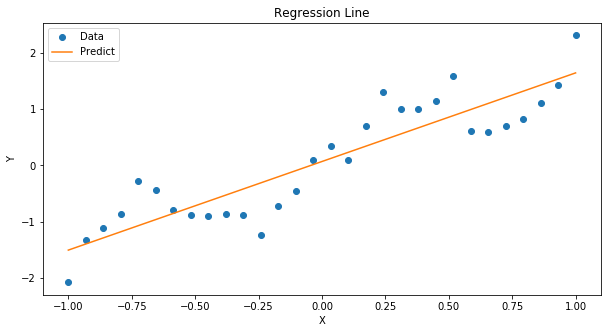

In [6]:
# get X
X = np.ones_like(artificial)
X[:, 1:] = artificial[:, [0]]
# get Y
Y = artificial[:, [1]]
# get n
n = artificial.shape[0]
# Calulcate W
W = np.linalg.solve(X.T @ X,  X.T @ Y)
# Calculate y_hat
Y_hat = X @ W
# Calculate MSE
mse = MSE(Y, Y_hat)

# Print results
print(f"Parametros: \n{W}")
print(f'MSE: {mse}')

# Plot
plt.title('Regression Line')
plt.plot(X[:, [1]], Y, 'o' ,label='Data')
plt.plot(X[:, [1]], Y_hat, label='Predict')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend();

### GD - (Gradiente Descendente)

Parametros:
[[-5.54371364e-17]
 [ 8.97488716e-01]]
MSE: 0.21340090135893613


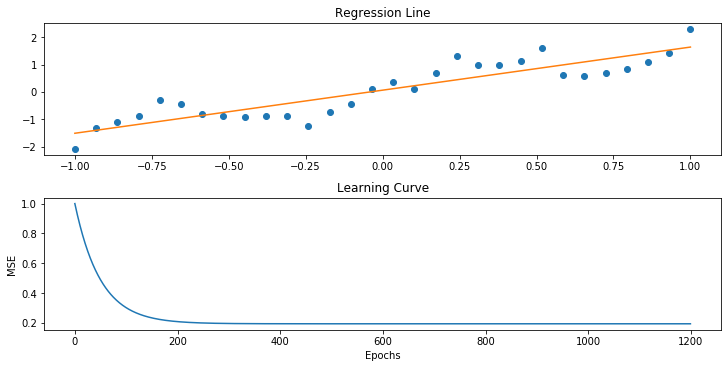

In [7]:
# Num. of observations
n = len(artificial)

# Get Features Matrix
X = artificial[:, :-1]
norm_X, _, _ = z_score_norm(X)
norm_X = np.c_[np.ones(n), norm_X]

# Get Labels vector
Y = artificial[:, [-1]]
norm_Y, norm, inv_norm = z_score_norm(Y)

# Hyperparameters
alpha = .01
n_epochs = 1200

# plot variables
learning_curve = []

# GD algorithm
w = np.zeros((norm_X.shape[1], 1))
for i in range(n_epochs):
    Y_hat = norm_X @ w
    
    # Calculate error
    e = norm_Y - Y_hat
    
    # Update w
    w += alpha * (norm_X.T @ e) / n

    # Calculate MSE    
    mse = MSE(norm_Y, Y_hat)
    learning_curve.append(mse)


print(f"Parametros:\n{w}")
print(f"MSE: {MSE(inv_norm(norm_X @ w), Y)}")

# Plot
fig, axes = plt.subplots(2,1,constrained_layout=True)

axes[0].set_title('Regression Line')
axes[0].plot(artificial[:, :-1], artificial[:, -1], 'o')
axes[0].plot(artificial[:, :-1], inv_norm(norm_X @ w), '-')

# Plot Learning Curve
axes[1].set_title('Learning Curve')
axes[1].plot(learning_curve)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE');



### SGD - (Gradiente Descendente Estocastico)

Parametros:
[[0.00323406]
 [0.89400104]]
MSE: 0.21342576189820173


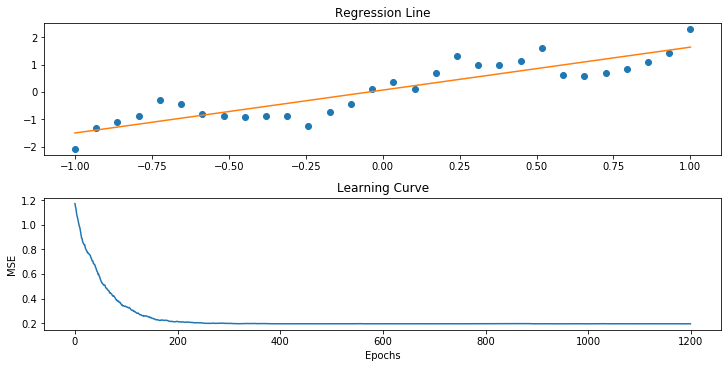

In [8]:
# Num. of observations
n = len(artificial)

# get X
X = artificial[:, :-1]
X, _, _ = z_score_norm(X)
X = np.c_[np.ones(n), X]

# get Y
Y = artificial[:, [-1]]
Y, norm, inv_norm = z_score_norm(Y) 

# Hyperparameters
alpha = .01
n_epochs = 1200

# plot variables
learning_curve = []

# GD Stocastic algorithm
w = np.ones((X.shape[1], 1))
for epoch in range(n_epochs):
        pos = epoch % n

        # Check if looped by all sample
        if(pos == 0):
            perm = np.random.permutation(range(n))
        
        i = perm[pos]
        
        # Get sample index i
        x = X[i:i+1]
        y = Y[i:i+1]
        
        # Calculate sample prediction
        y_hat = x @ w

        # Calculate error
        e = y - y_hat

        # update weights
        w += alpha * (e * x.T)

        # Calculate MSE 
        Y_hat = X @ w
        mse = MSE(Y, Y_hat)
        learning_curve.append(mse)

# Plot
fig, axes = plt.subplots(2,1,constrained_layout=True)

# Print
print(f"Parametros:\n{w}")
print(f"MSE: {MSE(inv_norm(X @ w), inv_norm(Y))}")

axes[0].set_title('Regression Line')
axes[0].plot(artificial[:, :-1], artificial[:, -1], 'o')
axes[0].plot(artificial[:, :-1], inv_norm(X @ w), '-')

# Plot Learning Curve
axes[1].set_title('Learning Curve')
axes[1].plot(learning_curve)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE');

## Questão 02  - Boston Dataset

### Train Test Split

In [9]:
boston = np.genfromtxt('./boston.csv', delimiter=',')

X = boston[:, :-1]
Y = boston[:, [-1]]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
n = len(y_train)

# Max degree for training
max_degree = 11

### Regressão Polinomial

In [10]:
def polyFeatures(X, degree=2, include_bias=True):
    
    poly_x = np.hstack([X**(i+1) for i in range(degree)])
    
    if(include_bias):
        poly_x = np.c_[np.ones(len(poly_x)), poly_x]
    
    return poly_x

In [11]:

def train_polinomial_model(x_train, x_test, y_train, y_test, degree, l2=1e-10):

    # Normalize Train
    norm_x_train, norm_x, _ = min_max_scaler(x_train)
    norm_y_train, norm_y, inv_norm = min_max_scaler(y_train)
    
    # Normalize Test
    norm_x_test = norm_x(x_test)
    
    # Create Poly features
    poli_x = polyFeatures(norm_x_train, degree)

    # Train
    w = OLS(poli_x, norm_y_train, l2)
    
    rmse_train = RMSE(y_train, inv_norm(poli_x @ w))
    
    # Test
    poli_x_test = polyFeatures(norm_x_test, degree)
    rmse_test = RMSE(y_test, inv_norm(poli_x_test @ w))
    
   
    return rmse_train, rmse_test

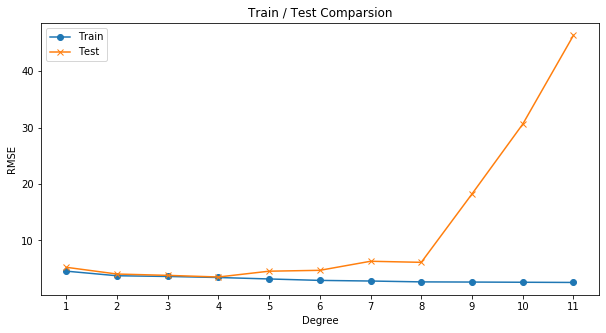

In [12]:
train_history = []
test_history = []

for degree in range(max_degree):
    train_error, test_error = train_polinomial_model(x_train, x_test, y_train, y_test, degree+1)
    train_history.append(train_error)
    test_history.append(test_error) 

plt.plot(range(1,max_degree+1), train_history, '-o', label='Train');
plt.plot(range(1,max_degree+1), test_history, '-x', label='Test');
plt.xticks(ticks=range(1,max_degree+1))
plt.title('Train / Test Comparsion')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.legend();

### Regressão Polinomial -  Normalização l2

Repita os 2 itens anteriores incluindo um termo de regularização L2 com fator $λ = 0.01$

Using l2 = 0.01


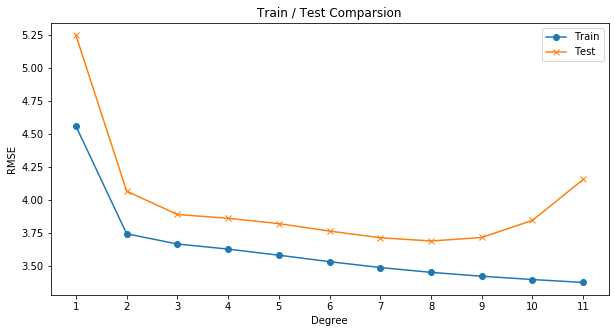

In [13]:
l2_value = 0.01

l2_train_history = []
l2_test_history = []

for degree in range(max_degree):
    train_error, test_error = train_polinomial_model(x_train, x_test, y_train, y_test, degree+1, l2_value)
    l2_train_history.append(train_error)
    l2_test_history.append(test_error)

print(f"Using l2 = {l2_value}")

plt.plot(range(1,max_degree+1), l2_train_history, '-o', label='Train');
plt.plot(range(1,max_degree+1), l2_test_history, '-x', label='Test');
plt.xticks(ticks=range(1,max_degree+1))
plt.title('Train / Test Comparsion')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.legend();